#### CSC 592 Introduction to Data Science Excercise - Assignment 3
##### Submitted by:
##### Name: Md Kausar Hamid Miji
##### Graduate Student: Computer Science and Engineering
##### and
##### Name: Sherwyn Braganza
##### Graduate Student: Computer Science and Engineering

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
# (This is Linux below - to do this in Windows just enter the url into a browser 
#  - that will save the file in the Downloads directory.  Then unzip - move data file into same directory as this notebook.)

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


**Inspecting the data of the Jena weather dataset**

In [53]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
# what is 'data' variable (type, etc)?

""" 

The 'data' is a str class object that contains our header which contains time series data in each column. 

"""

print(type(data))
print(len(data))
print(data[:1000])


<class 'str'>
43153572
"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,

In [54]:
lines = data.split("\n")
# what is 'lines' variable (type, etc)?

"""

The 'lines' is a list of str class objects that corresponds to sections of data seperated by a '\n'

"""

# how many lines are there?

"""

420452 (Including header)

"""

print(len(lines))
print(type(lines))
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

420452
<class 'list'>
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [55]:
import numpy as np
import pandas as pd
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

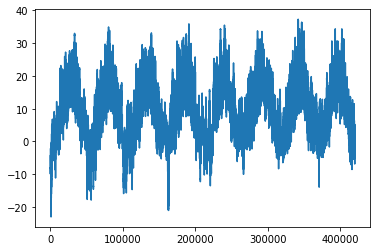

In [56]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

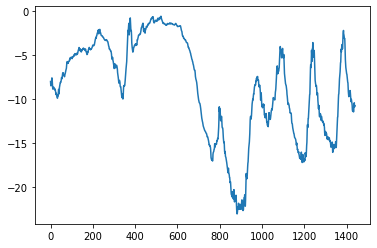

In [57]:
# WHAT IS THE PREDICTION PROBLEM WE'RE TRYING TO SOLVE
"""

We are trying to predict temperature of days in the future based on the trends/data
of the past. This is a regression problem and we will predict on continuous value.

"""
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [58]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [59]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# WHY DIDN'T WE DO THIS FOR THE VALIDATION AND TEST DATA AS WELL?

"""

Normalization changes the magnitude of the 'n' dimentional hypothetical
vector a sample represents, but not its direction/orientation.
With normalization, we can make the range of data similar for the all the
features of the dataset. This symmetric data help a model train better but has very
little scope and use past the training process. Normalization of test and
validation data would work and provide us with the same results, but is unnecessary.

"""

# WILL WE USE mean AND std AGAIN LATER, AND IF SO, HOW?

"""

Yes we will use the mean and std again, as the prediction we recieved would be
normalized. We would need to use the mean and std again to get it within scale.
raw_data = prediction X std + mean.

"""

'\n\nYes we will use the mean and std again, as the prediction we recieved would be\nnormalized. We would need to use the mean and std again to get it within scale.\nraw_data = prediction X std + mean.\n\n'

In [60]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)

# WHY IS OUR AUTHOR GENERATING AN INTEGER SEQUENCE FROM 0..9?

"""

The author just wanted to show us the use of the timesries_dataset_from_array utility works.
So, he generated a simple numpy array for this purpose.

"""

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print(inputs)
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64)
[0, 1, 2] 3
[1, 2, 3] 4
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64)
[2, 3, 4] 5
[3, 4, 5] 6
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64)
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [61]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [62]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
    
# WHAT IF WE LEAVE OUT THE BREAK?

"""
 
The "break" stops the loop after the first iteration. Leaving it in would make it iterate over the entire dataset.
 
 """

# WHY DOES OUR DATA HAVE THIS SHAPE?  WHAT'S ALONG EACH OF THE AXES?

"""

The data contains 14 features. It contains timeseries data for 5 days or 5x24 = 120 hours.
Each batch contains 256 samples.

"""

samples shape: (256, 120, 14)
targets shape: (256,)


'\n\nThe data contains 14 features. It contains timeseries data for 5 days or 5x24 = 120 hours.\nEach batch contains 256 samples.\n\n'

### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [63]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
#         print(samples.shape[0])
    print(samples_seen)
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

# EXPLAIN WHAT THE NAIVE METHOD IS DOING.

"""

Its generating a baseline predictive model. With out any actual machine learning model for training,
we just wanted to know how a simple mathematical operation predicts on our dataset. Then we will
compare this predition with the predition of our machine learning model to know how good our machine
learning model is doing.

"""

# WHAT IS MAE? wHAT ARE ITS UNITS?

"""

MAE stands for Mean Absolute Error. Its units are whatever the targets units are.
In this case, its degrees Celsius

"""

104393
Validation MAE: 2.44
103537
Test MAE: 2.62


'\n\nMAE stands for Mean Absolute Error. Its units are whatever the targets units are.\nIn this case, its degrees Celsius\n\n'

### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [64]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# WHAT DOES THIS MODEL LOOK LIKE? 

"""

This model consists of an  input layer, a Hidden Dense Layer and with an Output Dense
layer. The hiddden layer has a ReLU activation function and the output Dense layer does not
have any avctivation function as we are working with regression problem.

"""

# WHY DOESN'T THE LAST LAYER HAVE AN ACTIVATION FUNCTION?

"""

Its because we are looking for a regression like output, and not one thats constrained.
We will predict continuous value, not some discrete label.

"""

# DOES THE FACT THAT TWO SEQUENTIAL TIMES ARE NEXT TO EACH OTHER IN THE INPUT STILL MATTER HERE?  WHY OR WHY NOT?

""" 

I think it don't think it matters as from the Machine Learning Model's standpoint, 
it just looks like another sample with no relation to the next or previous.

"""

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

# WHAT'S THIS CALLBACK DOING FOR US?

"""

In out training phase, we will overfit the model after certain epochs.
Our model will perform best before the overfitting point. Callback is
used to save only the best performing model during this training phase.

"""

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 32s 38ms/step - loss: 17.5724 - mae: 3.2158 - val_loss: 11.9382 - val_mae: 2.7296
Epoch 2/10
819/819 [==============================] - 33s 40ms/step - loss: 9.8833 - mae: 2.4697 - val_loss: 10.9302 - val_mae: 2.6166
Epoch 3/10
819/819 [==============================] - 30s 36ms/step - loss: 8.8774 - mae: 2.3424 - val_loss: 11.0042 - val_mae: 2.6384
Epoch 4/10
819/819 [==============================] - 27s 33ms/step - loss: 8.3127 - mae: 2.2700 - val_loss: 12.5438 - val_mae: 2.8164
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 7.9615 - mae: 2.2208 - val_loss: 10.5693 - val_mae: 2.5786
Epoch 6/10
819/819 [==============================] - 29s 36ms/step - loss: 7.6907 - mae: 2.1820 - val_loss: 12.2805 - val_mae: 2.7581
Epoch 7/10
819/819 [==============================] - 31s 38ms/step - loss: 7.4720 - mae: 2.1534 - val_loss: 11.7412 - val_mae: 2.7095
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

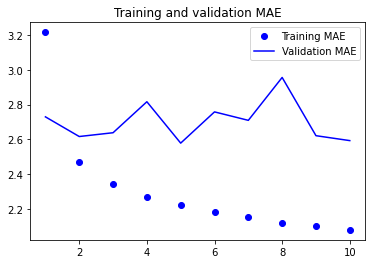

'\n\nThe shape of the validation error indicates that the model is overfitting.\n\n'

In [65]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# IS THIS METHOD WORKING BETTER OR WORSE THAN THE BASELINE METHOD? (HINT: LOOK AT VALIDATION)

"""

The gap between validation Train MAE and Validation MAE is larger than the baseline method.
This is worse than our baseline random model.

"""

# WHAT DOES THIS SHAPE OF VALIDATION ERROR INDICATE?

"""

The shape of the validation error indicates that the model is overfitting.

"""

### Let's try a 1D convolutional model

In [47]:
# IF I HAD AN INPUT SEQUENCE OF [1,2,3,0,2,1,3,2,1,2] AND A 1-D CONV MASK OF 
# [1,0,1], WHAT IS THE CONVOLUTION OUTPUT?

'''
Here, if we map the sequence with mask, we will get:
1 * 1 + 0 * 2 + 1 * 3 = 4
1 * 2 + 0 * 3 + 1 * 0 = 2
1 * 3 + 0 * 0 + 1 * 2 = 5
1 * 0 + 0 * 2 + 1 * 1 = 1
1 * 2 + 0 * 1 + 1 * 3 = 5
1 * 1 + 0 * 3 + 1 * 2 = 3
1 * 3 + 0 * 2 + 1 * 1 = 4
1 * 2 + 0 * 1 + 1 * 2 = 4

The output will be [4, 2, 5, 1, 5, 3, 4, 4]

'''

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# LOOK UP GLOBAL AVERAGE POOLING AND TRY TO FIGURE OUT WHAT IT IS.

"""

The global average pooling (GAP) layers are used to minimize overfitting by reducing
the total number of parameters in the model. Similar to max pooling layers, GAP layers
are used to reduce the spatial dimensions of a three-dimensional tensor. Even so, GAP
layers perform a more extreme type of dimensionality reduction, where a tensor with
dimensions H X W x L is reduced in size to have dimensions 1 X 1 X L. GAP layers reduce
each H X W feature map to a single number by simply taking the average of all HW values.

"""

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

# IS THIS METHOD WORKING BETTER OR WORSE THAN THE BASELINE METHOD? (HINT: LOOK AT VALIDATION)

"""

This model performs even worse than the densely connected one and the baseline model.

"""

Epoch 1/10
819/819 [==============================] - 41s 49ms/step - loss: 20.4732 - mae: 3.5439 - val_loss: 15.1646 - val_mae: 3.0573
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 14.9753 - mae: 3.0727 - val_loss: 15.1339 - val_mae: 3.0894
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 13.8461 - mae: 2.9454 - val_loss: 14.3999 - val_mae: 2.9935
Epoch 4/10
819/819 [==============================] - 35s 42ms/step - loss: 13.0528 - mae: 2.8518 - val_loss: 14.4395 - val_mae: 3.0102
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 12.4913 - mae: 2.7899 - val_loss: 14.1228 - val_mae: 2.9695
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 12.0213 - mae: 2.7367 - val_loss: 13.5130 - val_mae: 2.8930
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 11.6013 - mae: 2.6884 - val_loss: 15.1183 - val_mae: 3.0516
Epoch 8/10
819/819 [============================

'\n\nThis model performs even worse than the densely connected one and the baseline model.\n\n'

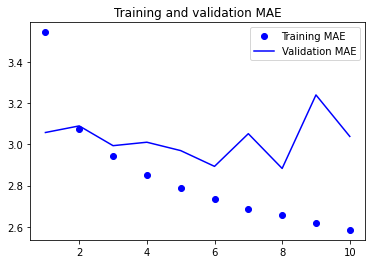

'\n\nSince this is a time series data, the features change with respect to time.\nEach samples are connected the past sample. The past data is informative for\npredidcting the future data. In our Conv1D model, we used max pooling and\nglobal average pooling layers and those layers largely destroyed the order\ninformation of our time series data. So, lack of proper data representation\nlead to such shape for validation error.\n\n'

In [48]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# IS THIS METHOD WORKING BETTER OR WORSE THAN THE BASELINE METHOD? (HINT: LOOK AT VALIDATION)

"""

This model performs even worse than the densely connected one and the baseline model.

"""

# WHAT DOES THIS SHAPE OF VALIDATION ERROR INDICATE?

"""

Since this is a time series data, the features change with respect to time.
Each samples are connected the past sample. The past data is informative for
predidcting the future data. In our Conv1D model, we used max pooling and
global average pooling layers and those layers largely destroyed the order
information of our time series data. So, lack of proper data representation
lead to such shape for validation error.

"""

### A first recurrent baseline

**A simple LSTM-based model**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 36s 42ms/step - loss: 38.8734 - mae: 4.5383 - val_loss: 12.1615 - val_mae: 2.6704
Epoch 2/10
819/819 [==============================] - 36s 44ms/step - loss: 11.0061 - mae: 2.5768 - val_loss: 9.6554 - val_mae: 2.4225
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 9.8881 - mae: 2.4516 - val_loss: 9.6029 - val_mae: 2.4119
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 9.3990 - mae: 2.3892 - val_loss: 9.8647 - val_mae: 2.4383
Epoch 5/10
819/819 [==============================] - 38s 47ms/step - loss: 9.0907 - mae: 2.3484 - val_loss: 9.9189 - val_mae: 2.4464
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 8.8371 - mae: 2.3111 - val_loss: 10.1171 - val_mae: 2.4691
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 8.6601 - mae: 2.2835 - val_loss: 9.8708 - val_mae: 2.4414
Epoch 8/10
819/819 [==============================] - 49s 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary